In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

In [2]:
plt.rcParams.update({
    'figure.figsize': (4, 4),
    'figure.dpi': 120,
    'font.family': 'serif',
    'font.size': 20,
    'axes.grid': True,
    'errorbar.capsize': 5,
    'lines.linewidth': 2,
    'lines.linestyle': 'dashed',
    'lines.markerfacecolor': 'none',
    'lines.markersize': 10,
})


In [3]:
data = np.load('rawdata_omnifold.npz')
weights = np.load('weights_omnifold.npz')
substructure_variables = ['m', 'M', 'w', 'tau21', 'zg', 'sdm']

# a dictionary to hold information about the observables
obs = {}

# the jet mass and histogram style information
obs.setdefault('m', {}).update({
    'xlim': (0, 75), 'ylim': (0, 0.065),
    'xlabel': r'Jet Mass', 'symbol': r'$m$ [GeV]',
    'stamp_xy': (0.425, 0.65),
})

# the constituent multiplicity and histogram style information
obs.setdefault('M', {}).update({
    'xlim': (0, 80), 'ylim': (0, 0.065),
    'xlabel': 'Jet Constituent Multiplicity', 'symbol': r'$M$',
    'stamp_xy': (0.42, 0.65),
})

# the jet width and histogram style information
obs.setdefault('w', {}).update({
    'xlim': (0, 0.6), 'ylim': (0, 10),
    'xlabel': r'Jet Width', 'symbol': r'$w$',
    'stamp_xy': (0.425, 0.65),
})

# the N-subjettiness ratio and histogram style information
obs.setdefault('tau21', {}).update({
    'xlim': (0, 1.2), 'ylim': (0, 3),
    'xlabel': r'$N$-subjettiness Ratio', 'symbol': r'$\tau_{21}^{(\beta=1)}$',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

# the groomed momentum fraction and histogram style information
obs.setdefault('zg', {}).update({
    'xlim': (0, 0.5), 'ylim': (0, 9),
    'xlabel': r'Groomed Jet Momentum Fraction', 'symbol': r'$z_g$',
    'stamp_xy': (0.425, 0.65),
})

# the groomed jet mass and histogram style information
obs.setdefault('sdm', {}).update({
    'xlim': (-14, -2), 'ylim': (0, 0.3),
    'xlabel': r'Soft Drop Jet Mass', 'symbol': r'$\ln\rho$',
    'stamp_xy': (0.41, 0.92),
    'legend_loc': 'upper left', 'legend_ncol': 1,
})

In [26]:
plot_kwargs = {
    'density': True,
    'alpha': 0.5,
    'linewidth': 4,
}
nbins = 20

series_configs = [
    {'label': 'Generation', 'color': 'C1',  'fmt': 'd', 'data_key': lambda var: f'{var}_true_alt', 'weights': None},
    {'label': 'OmniFold',   'color': 'red', 'fmt': '^', 'data_key': lambda var: f'{var}_true_alt', 'weights':  weights['unfolded_weights'], 'linestyle': 'dashed'},
    {'label': 'RAN',        'color': 'black', 'fmt': 'o', 'data_key': lambda var: f'{var}_true',     'weights':  np.abs(weights['ran_weights']), 'linestyle': 'solid'},
        {
        'label': 'IBU',
        'color': 'green',
        'fmt': 's',
        'linestyle': 'dotted',
        'weights': None,
        'data_key': lambda var: f'{var}_reco'  # Not actually used for IBU
    }
]




In [29]:
def plot_substructure(ax_main, ax_ratio, var, use_ibu_bins=True):
    # Choose bins based on whether to use IBU bins
    if use_ibu_bins and var in var_to_dim:
        dim_idx = var_to_dim[var]
        plot_kwargs['bins'] = ibu_bins[dim_idx]
        print(f"Using IBU bins for {var} (dimension {dim_idx})")
    else:
        plot_kwargs['bins'] = np.linspace(*obs[var]['xlim'], nbins)
        print(f"Using default bins for {var}")
    
    # Plot truth histogram
    counts_true, bin_edges, _ = ax_main.hist(data[f'{var}_true'], label='Truth', **plot_kwargs)
    
    # IMPORTANT: Resize counts array to match number of series_configs
    n_methods = len(series_configs)
    counts = np.empty((len(counts_true), n_methods), dtype=np.single)
    
    # Plot RAN and OmniFold histograms as before - DON'T CHANGE THIS PART
    for i, cfg in enumerate(series_configs):
        # Skip IBU - we'll handle it separately
        if cfg['label'] == 'IBU':
            continue
            
        kwargs = dict(**plot_kwargs)
        if cfg['label'] in ['OmniFold', 'RAN']:
            kwargs['histtype'] = 'step'
            kwargs['linestyle'] = cfg['linestyle']
        kwargs['color'] = cfg['color']
        kwargs['weights'] = cfg['weights']
        kwargs['label'] = cfg['label']
        counts[:, i], _, _ = ax_main.hist(data[cfg['data_key'](var)], **kwargs)
    
    # Add IBU if available - this is the only part we're changing
    ibu_idx = next((i for i, cfg in enumerate(series_configs) if cfg['label'] == 'IBU'), None)
    if ibu_idx is not None and 'ibu_hist' in globals():
        try:
            dim_idx = var_to_dim[var]
            
            # Use a dummy projection if we don't have the actual histogram
            if ibu_hist is None:
                # Just create a flat histogram as placeholder
                ibu_1d = np.ones_like(counts_true)
            else:
                # Get the 1D projection for this variable
                ibu_1d = get_1d_projection(ibu_hist, dim_idx)
            
            # Scale IBU histogram to match the normalization
            scale_factor = np.sum(counts_true) / np.sum(ibu_1d)
            ibu_1d_scaled = ibu_1d * scale_factor
            
            # Store IBU counts
            counts[:, ibu_idx] = ibu_1d_scaled
            
            # Get bin centers for plotting
            bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
            
            # For step plot - make sure dimensions match
            # With where='post', we need len(bin_edges)-1 values for proper display
            ax_main.step(bin_edges[:-1], ibu_1d_scaled, where='post',
                        color=series_configs[ibu_idx]['color'], 
                        linestyle=series_configs[ibu_idx]['linestyle'],
                        label=series_configs[ibu_idx]['label'])
        except Exception as e:
            print(f"Error plotting IBU for {var}: {e}")
            # Fill with zeros if there's an error
            if ibu_idx is not None:
                counts[:, ibu_idx] = 0
    
    # Rest of the function remains the same
    if 'ylim' in obs[var]:
        ax_main.set_ylim(obs[var]['ylim'])
    ax_main.set_ylabel('Density')
    ax_main.set_xlabel('')
    ax_main.tick_params(labelbottom=False)
    ax_main.legend(
        loc=obs[var].get('legend_loc', 'best'),
        fontsize=16, ncol=obs[var].get('legend_ncol', 1)
        )
    ax_main.set_title(f"{obs[var]['xlabel']}:\nParticle level")

    # Get bin centers for ratio plot
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    counts_true = counts_true[:, np.newaxis]
    ratios = np.divide(counts, counts_true, where=(counts_true != 0))
    errors = ratios * np.sqrt(1 / counts + 1 / counts_true) / 360
    
    for i, cfg in enumerate(series_configs):
        # Skip plotting ratio if we have all zeros
        if np.all(counts[:, i] == 0):
            continue
            
        ax_ratio.errorbar(bin_centers, ratios[:, i], fmt=cfg['fmt'],
                          yerr=errors[:, i],
                          color=cfg['color'],
                          label=cfg['label'],
                          linestyle='dashed')
    ax_ratio.axhline(1.0, color='red')

    ax_ratio.set_ylim(0.85, 1.15)
    ax_ratio.set_ylabel('Ratio\ntoTruth')
    ax_ratio.set_xlabel(obs[var]['symbol'])

Using IBU bins for m (dimension 0)
Using IBU bins for M (dimension 1)
Using IBU bins for w (dimension 2)
Using IBU bins for tau21 (dimension 3)
Using IBU bins for zg (dimension 4)
Using IBU bins for sdm (dimension 5)


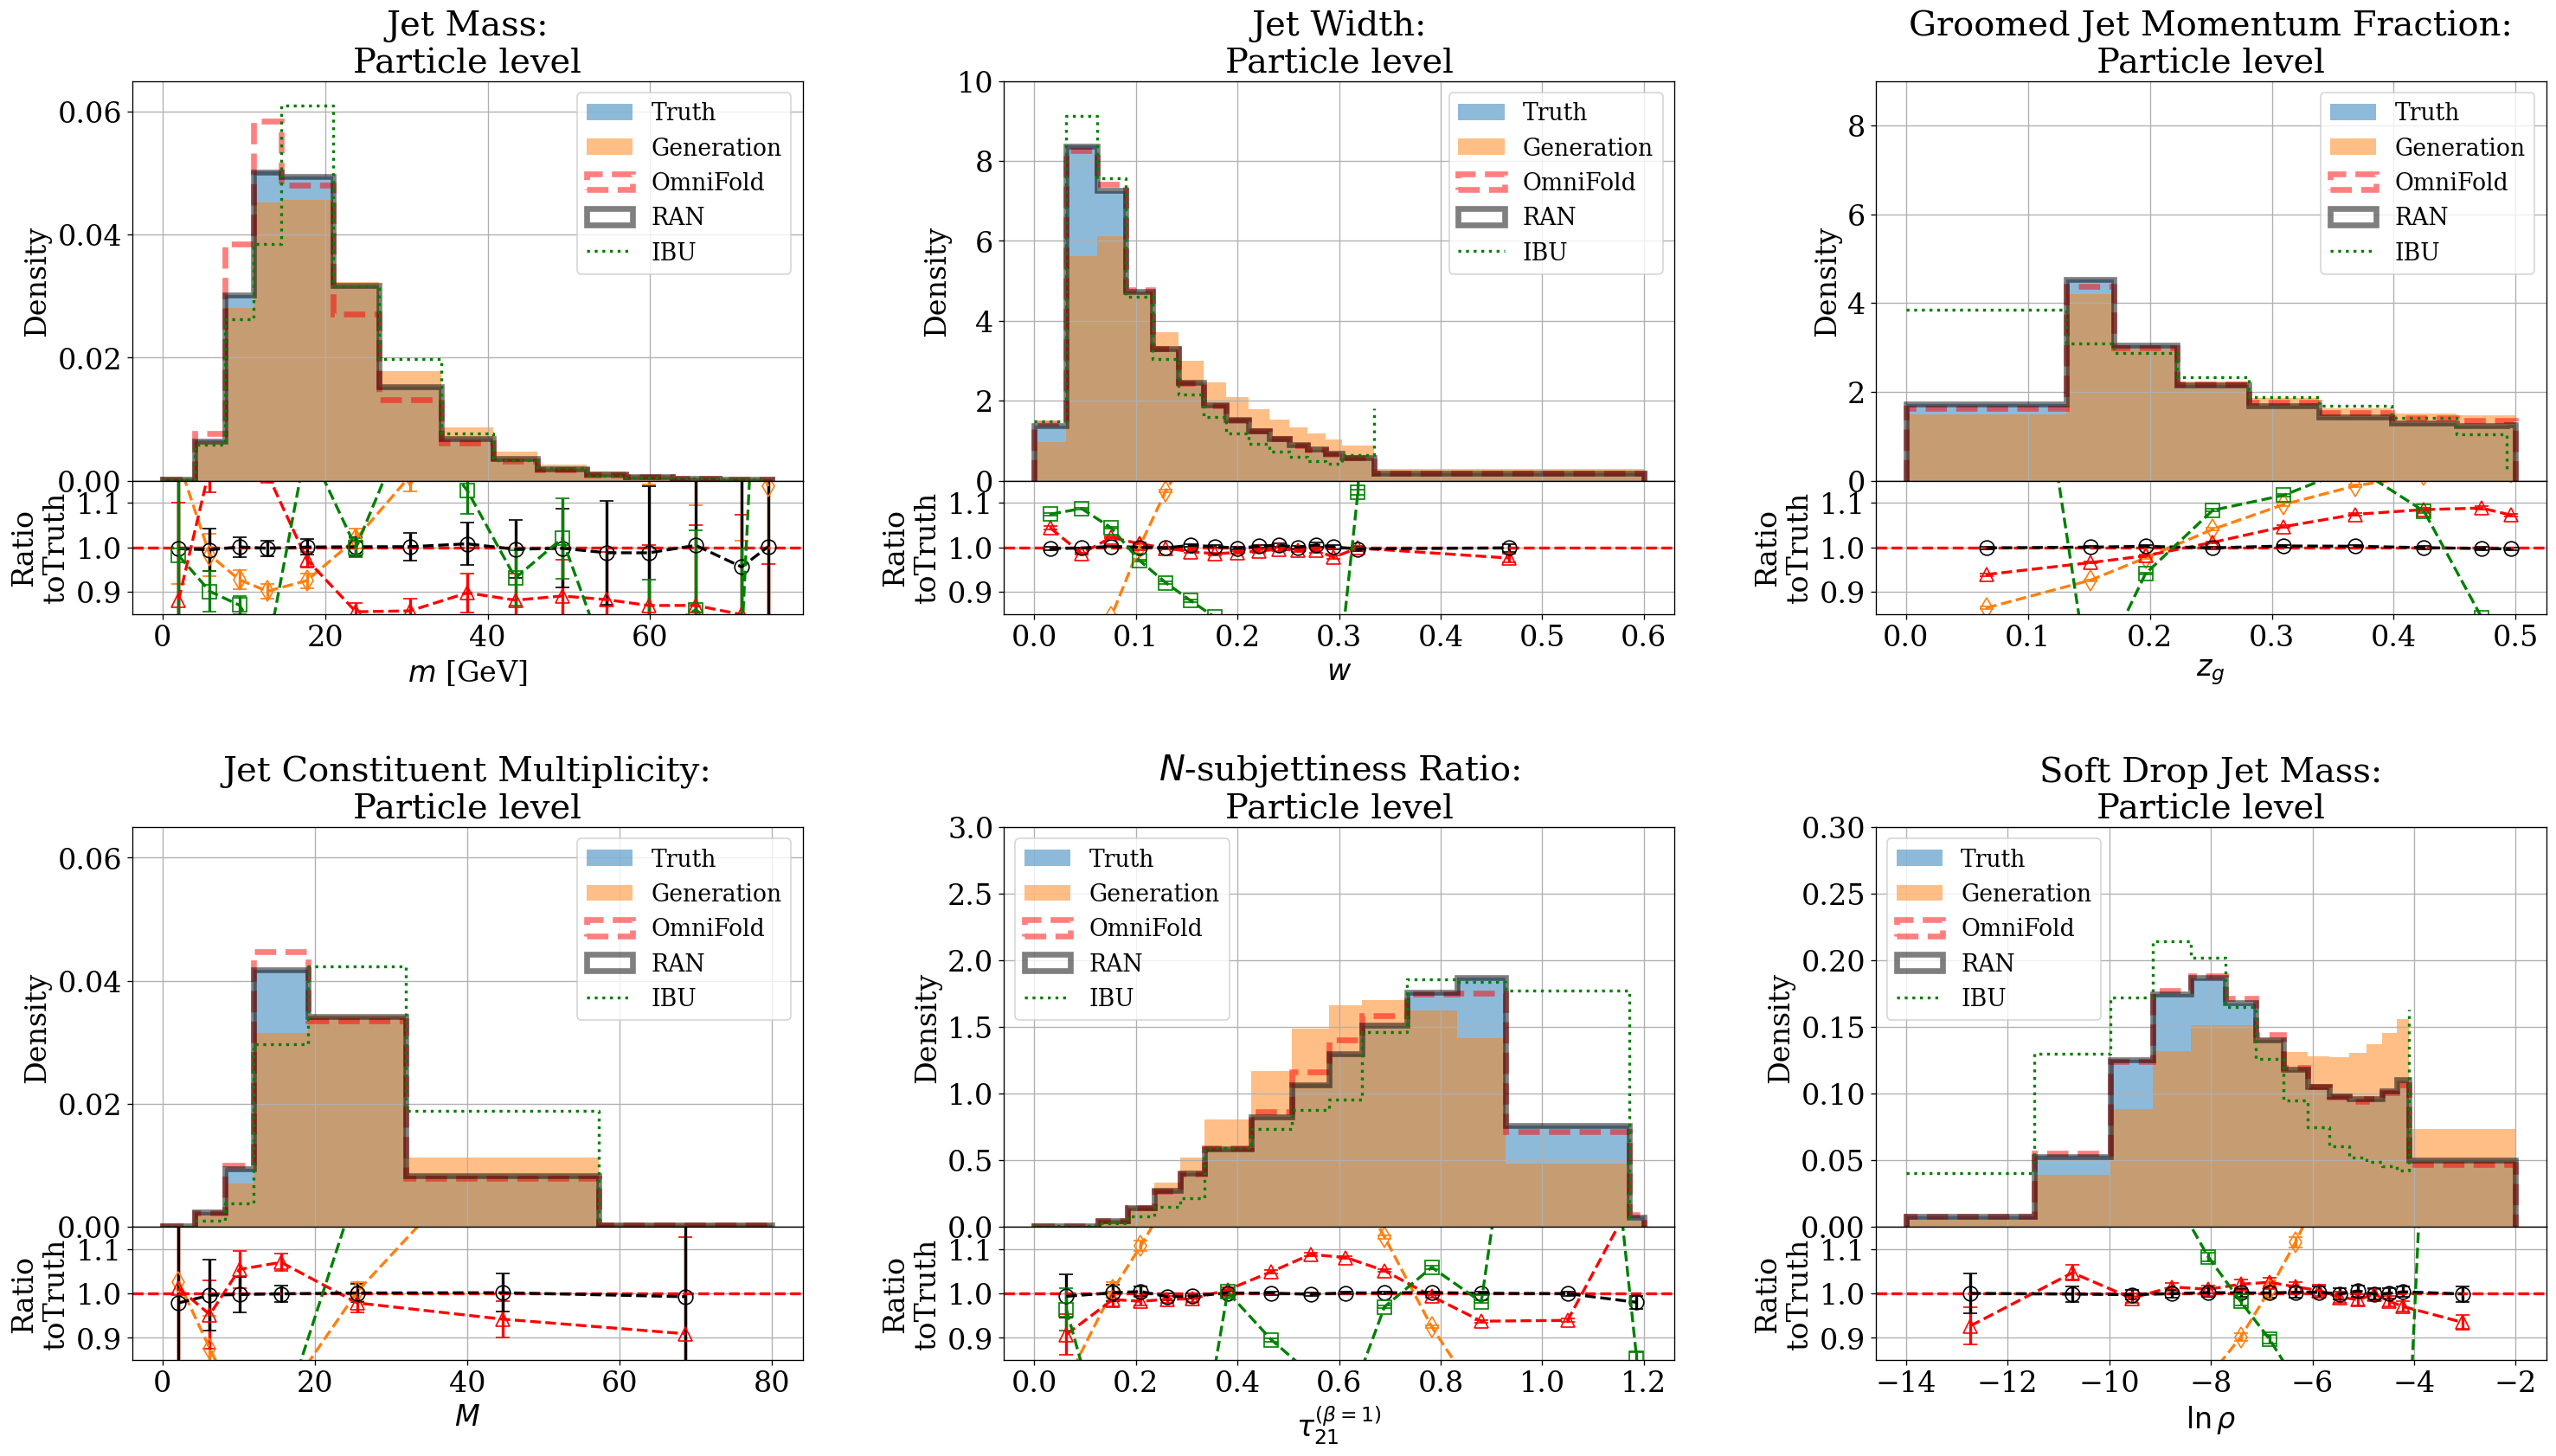

In [30]:
fig = plt.figure(figsize=(30, 16))
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.3)

for i, var in enumerate(substructure_variables):
    row = i % 2
    col = i // 2

    sub_gs = gs[row, col].subgridspec(2, 1, height_ratios=[3, 1], hspace=0)
    ax_main = fig.add_subplot(sub_gs[0])
    ax_ratio = fig.add_subplot(sub_gs[1], sharex=ax_main)
    
    # Use IBU bins for all variables
    plot_substructure(ax_main, ax_ratio, var, use_ibu_bins=True)

plt.savefig("six_var_with_ratio.pdf", bbox_inches='tight')
plt.show()

In [20]:
from scipy.stats import wasserstein_distance
import numpy as np

def histogram_to_sample(hist, bin_edges, n_samples=10000):
    """
    Convert a histogram to a representative sample
    
    Parameters:
    - hist: 1D histogram array
    - bin_edges: Bin edges for the histogram
    - n_samples: Number of samples to generate
    
    Returns:
    - Representative sample from the histogram
    """
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    bin_probs = hist / np.sum(hist)
    
    # Sample bin indices according to bin probabilities
    bin_indices = np.random.choice(len(bin_probs), size=n_samples, p=bin_probs)
    
    # Add some random jitter within each bin
    bin_widths = np.diff(bin_edges)
    samples = bin_centers[bin_indices] + (np.random.random(n_samples) - 0.5) * bin_widths[bin_indices]
    
    return samples

# Calculate Wasserstein distances
print("\nWasserstein Distances (×10):")
print("---------------------------")

for var in substructure_variables:
    print(f"\n{var}")
    
    # Calculate for RAN and OmniFold as before
    for i, cfg in enumerate(series_configs):
        if cfg['label'] == 'IBU':
            continue  # Skip IBU in this loop
            
        data_key = cfg['data_key'](var)
        distance = wasserstein_distance(
            data[f'{var}_true'], 
            data[data_key], 
            v_weights=cfg['weights']
        ) * 10
        print(f"{cfg['label']} vs. Truth: {distance:.4f}")
    
    # Calculate for IBU
    if 'ibu_hist' in globals() and ibu_hist is not None:
        try:
            # Get dimension index and IBU projection for this variable
            dim_idx = var_to_dim[var]
            ibu_1d = get_1d_projection(ibu_hist, dim_idx)
            
            # Get bin edges for this variable
            bin_edges = ibu_bins[dim_idx]
            
            # Convert histogram to sample
            ibu_samples = histogram_to_sample(ibu_1d, bin_edges)
            
            # Calculate Wasserstein distance
            distance = wasserstein_distance(
                data[f'{var}_true'], 
                ibu_samples
            ) * 10
            print(f"IBU vs. Truth: {distance:.4f}")
        except Exception as e:
            print(f"Error calculating IBU distance for {var}: {e}")


Wasserstein Distances (×10):
---------------------------

m
Generation vs. Truth: 11.7093
Omnifold vs. Truth: 11.0213
RAN vs. Truth: 0.1154
IBU vs. Truth: 10.4003

M
Generation vs. Truth: 25.3883
Omnifold vs. Truth: 4.5876
RAN vs. Truth: 0.1188
IBU vs. Truth: 16.0744

w
Generation vs. Truth: 0.2695
Omnifold vs. Truth: 0.0081
RAN vs. Truth: 0.0006
IBU vs. Truth: 0.0528

tau21
Generation vs. Truth: 0.5505
Omnifold vs. Truth: 0.0784
RAN vs. Truth: 0.0015
IBU vs. Truth: 0.1521

zg
Generation vs. Truth: 0.1285
Omnifold vs. Truth: 0.0632
RAN vs. Truth: 0.0008
IBU vs. Truth: 0.1918

sdm
Generation vs. Truth: 6.1541
Omnifold vs. Truth: 0.4172
RAN vs. Truth: 0.0200
IBU vs. Truth: 1.0309


In [21]:
for var in substructure_variables:
    print(f"\n{var}")
    for i, cfg in enumerate(series_configs):
        data_key = cfg['data_key'](var)
        print(f"{cfg['label']} vs. Truth: {wasserstein_distance(data[f'{var}_true'], data[data_key], v_weights=cfg['weights'])*10}")


m
Generation vs. Truth: 11.709347231303349
Omnifold vs. Truth: 11.021278438544504
RAN vs. Truth: 0.11539144136904898
IBU vs. Truth: 33.420049861590314

M
Generation vs. Truth: 25.38832894414123
Omnifold vs. Truth: 4.587554384741754
RAN vs. Truth: 0.11883774531306457
IBU vs. Truth: 71.07710411763482

w
Generation vs. Truth: 0.2695028343281278
Omnifold vs. Truth: 0.008065534527718642
RAN vs. Truth: 0.0005937671169442523
IBU vs. Truth: 0.18165500014265734

tau21
Generation vs. Truth: 0.5505362630584494
Omnifold vs. Truth: 0.07839818074520283
RAN vs. Truth: 0.0015130990083141145
IBU vs. Truth: 0.6027078322173941

zg
Generation vs. Truth: 0.12852250503973522
Omnifold vs. Truth: 0.06324592046741491
RAN vs. Truth: 0.0007633313890321935
IBU vs. Truth: 0.09739966288986045

sdm
Generation vs. Truth: 6.154107206464307
Omnifold vs. Truth: 0.4171677748103187
RAN vs. Truth: 0.02001066181944086
IBU vs. Truth: 3.7842573251393037


In [16]:
for var in substructure_variables:
    print(f"\n{var}")
    print(wasserstein_distance(data[f'{var}_true'], data[f'{var}_reco'])*10)


m
33.420049861590314

M
71.07710411763482

w
0.18165500014265734

tau21
0.6027078322173941

zg
0.09739966288986045

sdm
3.7842573251393037


In [24]:
import numpy as np

def vlc_distance(hist1, hist2, epsilon=1e-10):
    """
    Calculate the VLC distance between two histograms
    
    VLC distance is defined as:
    ∆(p,q) = (1/2) ∫ (p(λ)-q(λ))²/(p(λ)+q(λ)) dλ × 10³
    
    Parameters:
    - hist1: First histogram (array)
    - hist2: Second histogram (array)
    - epsilon: Small value to avoid division by zero
    
    Returns:
    - VLC distance (×10³)
    """
    # Ensure histograms are normalized
    p = hist1 / np.sum(hist1)
    q = hist2 / np.sum(hist2)
    
    # Calculate the numerator and denominator
    numerator = (p - q)**2
    denominator = p + q + epsilon
    
    # Calculate the integrand and sum (integrate)
    integrand = np.divide(numerator, denominator, where=denominator>epsilon)
    vlc = 0.5 * np.sum(integrand)
    
    # Multiply by 10³ for readability
    return vlc * 1000

def calculate_vlc_distances(data, ibu_hist=None, ibu_bins=None):
    """
    Calculate VLC distances for RAN, OmniFold, IBU, Gen, and Reco
    """
    results = {}
    
    print("\nVLC Distances (×10³):")
    print("---------------------------")
    
    for var in substructure_variables:
        results[var] = {}
        print(f"\n{var}")
        
        # Get dimension index for this variable
        dim_idx = var_to_dim.get(var)
        if dim_idx is None:
            print(f"No dimension mapping for {var}")
            continue
        
        # Get bins for this variable (preferably from IBU)
        if ibu_bins is not None and dim_idx < len(ibu_bins):
            bin_edges = ibu_bins[dim_idx]
        else:
            # Fallback to regular bins
            bin_edges = np.linspace(*obs[var]['xlim'], 50)
            
        # Create truth histogram
        truth_hist, _ = np.histogram(data[f'{var}_true'], bins=bin_edges)
        
        # Calculate VLC for RAN and OmniFold
        methods_data = {}
        for cfg in series_configs:
            if cfg['label'] == 'IBU':
                continue  # Handle IBU separately
                
            # Get data for this method
            data_key = cfg['data_key'](var)
            method_hist, _ = np.histogram(
                data[data_key], 
                bins=bin_edges, 
                weights=cfg['weights']
            )
            
            # Store for later output in correct order
            methods_data[cfg['label']] = method_hist
            
            # Calculate VLC distance
            vlc = vlc_distance(truth_hist, method_hist)
            results[var][cfg['label']] = vlc
        
        # Calculate VLC for IBU if available
        if ibu_hist is not None:
            try:
                # Get 1D projection for this variable
                ibu_1d = get_1d_projection(ibu_hist, dim_idx)
                
                # Store for later
                methods_data['IBU'] = ibu_1d
                
                # Calculate VLC distance
                vlc = vlc_distance(truth_hist, ibu_1d)
                results[var]['IBU'] = vlc
            except Exception as e:
                print(f"Error calculating IBU VLC distance for {var}: {e}")
                results[var]['IBU'] = None
        else:
            results[var]['IBU'] = None
        
        # Calculate VLC for Gen data (true_alt)
        try:
            gen_hist, _ = np.histogram(data[f'{var}_true_alt'], bins=bin_edges)
            methods_data['Gen'] = gen_hist
            vlc = vlc_distance(truth_hist, gen_hist)
            results[var]['Gen'] = vlc
        except KeyError:
            print(f"No '{var}_true_alt' data available")
            results[var]['Gen'] = None
        
        # Calculate VLC for Reco data (raw reconstructed)
        reco_hist, _ = np.histogram(data[f'{var}_reco'], bins=bin_edges)
        methods_data['Reco'] = reco_hist
        vlc = vlc_distance(truth_hist, reco_hist)
        results[var]['Reco'] = vlc
        
        # Print results in the specified order: RAN, OmniFold, IBU, Gen, Reco
        print(f"VLC Distances for {var} (×10³):")
        for method in ['RAN', 'Omnifold', 'IBU', 'Gen', 'Reco']:
            if method in results[var] and results[var][method] is not None:
                print(f"  {method:8} vs. Truth: {results[var][method]:.4f}")
            else:
                print(f"  {method:8} vs. Truth: N/A")
    
    return results

In [25]:
# Check if we have IBU data
if 'ibu_hist' in globals() and ibu_hist is not None:
    ibu_for_vlc = ibu_hist
    ibu_bins_for_vlc = ibu_bins
else:
    print("IBU histogram not available for VLC distance calculation")
    ibu_for_vlc = None
    ibu_bins_for_vlc = None

# Calculate VLC distances with all comparisons
vlc_results = calculate_vlc_distances(
    data,
    ibu_hist=ibu_for_vlc,
    ibu_bins=ibu_bins_for_vlc
)

# Print a summary table of all VLC distances
print("\nVLC Distance Summary Table (×10³):")
print("-" * 60)
headers = ['Variable', 'RAN', 'Omnifold', 'IBU', 'Gen', 'Reco']
print(f"{headers[0]:10} | {headers[1]:8} | {headers[2]:8} | {headers[3]:8} | {headers[4]:8} | {headers[5]:8}")
print("-" * 60)

for var in substructure_variables:
    if var in vlc_results:
        row = [var]
        for method in headers[1:]:
            if method in vlc_results[var] and vlc_results[var][method] is not None:
                row.append(f"{vlc_results[var][method]:.4f}")
            else:
                row.append("N/A")
        print(f"{row[0]:10} | {row[1]:8} | {row[2]:8} | {row[3]:8} | {row[4]:8} | {row[5]:8}")


VLC Distances (×10³):
---------------------------

m
VLC Distances for m (×10³):
  RAN      vs. Truth: 0.0023
  Omnifold vs. Truth: 5.0615
  IBU      vs. Truth: 5.1189
  Gen      vs. Truth: 3.4924
  Reco     vs. Truth: 52.2481

M
VLC Distances for M (×10³):
  RAN      vs. Truth: 0.0005
  Omnifold vs. Truth: 0.6323
  IBU      vs. Truth: 0.5471
  Gen      vs. Truth: 12.8882
  Reco     vs. Truth: 136.5670

w
VLC Distances for w (×10³):
  RAN      vs. Truth: 0.0012
  Omnifold vs. Truth: 0.0746
  IBU      vs. Truth: 0.0706
  Gen      vs. Truth: 21.8567
  Reco     vs. Truth: 22.5467

tau21
VLC Distances for tau21 (×10³):
  RAN      vs. Truth: 0.0009
  Omnifold vs. Truth: 0.7908
  IBU      vs. Truth: 1.7511
  Gen      vs. Truth: 20.3380
  Reco     vs. Truth: 25.8020

zg
VLC Distances for zg (×10³):
  RAN      vs. Truth: 0.0008
  Omnifold vs. Truth: 0.6847
  IBU      vs. Truth: 1.1904
  Gen      vs. Truth: 2.9173
  Reco     vs. Truth: 1.4902

sdm
VLC Distances for sdm (×10³):
  RAN      vs. T